## **MNIST dataset**

1) download dataset da torchvision

2) plot immagini originali

3) torchvision.transforms per data preparation + plot


In [ ]:
import torch
import torchvision
import torchvision.transforms as T

Download dataset da torchvision

In [121]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True
)


Plot di qualche immagine random dal train dataset

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import random

Image type: <class 'PIL.Image.Image'> - Image shape: (28, 28) - max pixel 255 - min pixel 0
Target: 9 - Label: bottle -  Target type: <class 'int'>


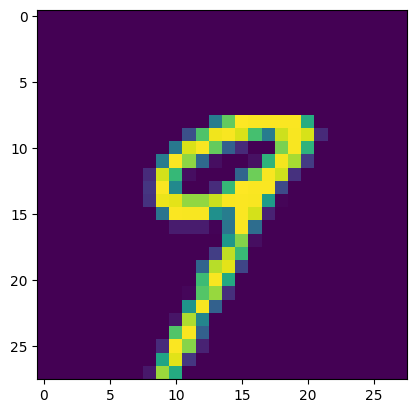

In [122]:
idx = random.randint(0, len(train_dataset))
image, target = train_dataset[idx]
print(f"Image type: {type(image)} - Image shape: {image.size} - max pixel {np.array(image).max()} - min pixel {np.array(image).min()}")
print(f"Target: {target} -  Target type: {type(target)}")
plt.imshow(image)

Aggiugiamo data transformation ai dataset di train e test

In [ ]:
train_dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

test_dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

Plot di qualche immagine random dal dataset di train

Image type: <class 'torch.Tensor'> - Image shape: torch.Size([1, 28, 28]) - max pixel 1.0 - min pixel -1.0
Target: 1 - Target type: <class 'int'>


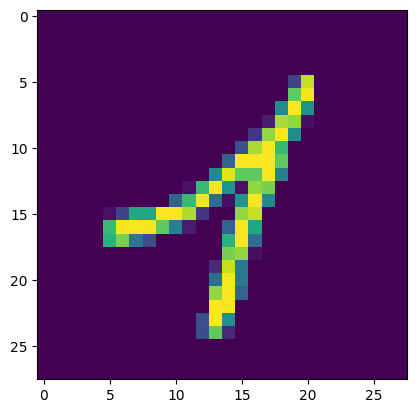

In [ ]:
idx = random.randint(0, len(train_dataset))
image, target = train_dataset[idx]
print(f"Image type: {type(image)} - Image shape: {image.shape} - max pixel {image.max()} - min pixel {image.min()}")
print(f"Target: {target} - Target type: {type(target)}")
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

## **PyTorch DataLoader**

* `DataLoader` è una classe di `PyTorch` che ha il compito di generare batch di dati.

* `DataLoader` è una classe si può inserire all'interno di un for-loop. Ad ogni iterazione restituirà un batch che contiene (images, targets):
  * images --> (N, C, H, W) --> N=batch_size, C=channel, H=height, W=width
  * targets --> (N) --> N=batch_size

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size=16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
images, targets = next(iter(train_loader))
images.shape, targets.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [ ]:
val_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torchvision

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

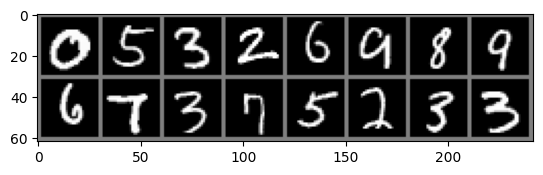

In [ ]:
# Plot some training images
images, targets = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

## **Neural Net + Training**

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])
batch_size = 64

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_dim: int, num_classes: int) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(input_dim, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.head = nn.Linear(64, num_classes)
        self.relu = nn.ReLU() # non ha pesi, quindi posso usare sempre la stessa

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        logits = self.head(x)
        return logits

In [ ]:
model = Net(input_dim=28*28, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# device = "cuda:0"
device = "cpu"
model.to(device);

In [ ]:
# Train the neural network
num_epochs = 5
log_every_n_iter = 250
for epoch in range(num_epochs):
  # train loop
  model.train()
  epoch_loss = 0.0
  print(f"Epoch: {epoch}")
  for i, batch in enumerate(train_loader, 0):
    # batch --> (images, targets)
    x, targets = [el.to(device) for el in batch]
    # set optimizer a zero
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    # calcolo della loss
    loss = criterion(logits, targets)
    # backward pass
    loss.backward()
    # optimizer step --> update weights
    optimizer.step()
    epoch_loss += loss.item()
    if (i+1) % log_every_n_iter == 0:    # Print every log_every_n_iter mini-batches
        print(f"> iter [{i+1}/{len(train_loader)}] - train_loss={epoch_loss/log_every_n_iter:.4f}")
        epoch_loss = 0.0
    # test loop
  model.eval()
  test_loss = []
  total, correct = 0, 0
  with torch.no_grad():
    for batch in test_loader:
      x, targets = [el.to(device) for el in batch]
      logits = model(x)
      loss = criterion(logits, targets)
      test_loss.append(loss.item())
      # ottengo gli indici dove trovo la max probabilità
      _, preds = torch.max(logits.data, 1)
      total += targets.size(0)
      correct += (preds == targets).sum().item()

  print("Test report:")
  print(f"test_loss={sum(test_loss)/len(test_loss):.4f} - test_accuracy={correct/total:.4f}")

  print(" \n *************** \n")


print('Finished Training')

Epoch: 0
> iter [250/938] - train_loss=2.2819
> iter [500/938] - train_loss=2.2469
> iter [750/938] - train_loss=2.2042
Test report:
test_loss=2.1276 - test_accuracy=0.3711
 
 *************** 

Epoch: 1
> iter [250/938] - train_loss=2.0950
> iter [500/938] - train_loss=2.0169
> iter [750/938] - train_loss=1.9164
Test report:
test_loss=1.7600 - test_accuracy=0.5828
 
 *************** 

Epoch: 2
> iter [250/938] - train_loss=1.7047
> iter [500/938] - train_loss=1.5753
> iter [750/938] - train_loss=1.4322
Test report:
test_loss=1.2508 - test_accuracy=0.7181
 
 *************** 

Epoch: 3
> iter [250/938] - train_loss=1.2013
> iter [500/938] - train_loss=1.1012
> iter [750/938] - train_loss=1.0165
Test report:
test_loss=0.8959 - test_accuracy=0.7912
 
 *************** 

Epoch: 4
> iter [250/938] - train_loss=0.8866
> iter [500/938] - train_loss=0.8184
> iter [750/938] - train_loss=0.7744
Test report:
test_loss=0.7027 - test_accuracy=0.8246
 
 *************** 

Finished Training


### Inference

In [ ]:
idx = random.randint(0, len(test_dataset))
img, target = test_dataset[idx]
print(img.shape)
# we need to augment the first dimension --> from (C, H, W) -> (B, C, H, W)
x = img.unsqueeze(0)
print(x.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [ ]:
import torch.nn.functional as F

with torch.no_grad():
  model.eval()
  logits = model(x)
  probs = F.softmax(logits, 1)
  print(probs.data)
  pred_prob, pred_class= torch.max(probs.data, 1)
  print(pred_class, pred_prob)

tensor([[2.8302e-02, 3.6601e-03, 5.5461e-01, 3.2108e-03, 2.0419e-02, 1.4803e-02,
         3.0847e-01, 3.9528e-04, 6.4394e-02, 1.7347e-03]])
tensor([2]) tensor([0.5546])


In [ ]:
np_img = img.numpy() # (C, W, H)
np_img = np.transpose(np_img, (1, 2, 0)) # (W, H, C)
print(np_img.shape)

(28, 28, 1)


Predicted class is 2 with prob=0.5546


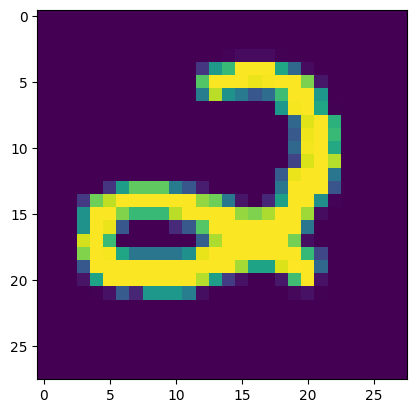

In [ ]:
print(f"Predicted class is {pred_class[0]} with prob={pred_prob[0]:.4f}")
plt.imshow(np_img)